# Hands-on Gene Drive Modelling
26/01/2026 Tin-Yu Hui

#### 1. Features of a basic gene drive simulator
This simplified gene drive simulation is based on Deredec et al. (2008). Nonetheless it remains as a complex system involving various ecological/evolutionary forces. Let me introduce the components one by one:

##### 1.1 force #1: drift
We continue to assume random mating. The <code>sample()</code> function remains useful. Population size is expected to change over time, so we give it a subscript $N_t$. 

##### 1.2 force #2: drive
In this one-locus, two-allele system, allele "0" is the wildtype (WT) and "1" is the artificially introduced transgene (TG). All mosquitoes carry "00" homozygotes before our release. 

The super-Mendelian inheritance of TG means there are more TG gametes produced by the heterozygote parents. We assume a heterozygote parent produces WT gamete "0" with proportion $(1-d)$, and TG gamete "1" with $d$, $d>0.5$. We call $d$ the transmission rate. This allows TG to spread from a low initial frequency. 

Note: $d=0.5$ for Mendelian inheritance. 

##### 1.3 force #3: selection
The increase in TG frequency does not necessary result in population decline unless there is a fitness cost. The model assumes TG "11" homozogytes are not viable and will not develop into adults, thus have a relative fitness of 0. The WT "00" homozygotes have a relative fitness of 1. We further assume the heterozygotes are just as fit as the WT homozygotes (dominance coefficient of $h=0$). 

##### 1.4 force #4: Population dynamics
$N$ appears to be monotonically decreasing without any regulatory mechanism. This makes our simulator unrealistic and boring. Here we introduce the Beverton-Holt model to model the lack of intra-specific competition under low densities: 

$$N_{t+1}=\frac{R_0N_t}{1+N_t/M}$$

The model regulates $N_t$ over time by introducing two additional parameters: $R_0$ and $M$. $R_0$ is the natural growth rate and $(R_0-1)M$ is the carrying capacity. It is the discrete analogue of logistic growth. 

#### 2. Some coding considerations
Before we proceed, let us study the aggregated effects of drive and selection on gametic frequencies. Conbining both forces, we learn that "00" homozygotes produce "0" gametes with probability 1. Heterozygotes produce "0" gametes with probability $(1-d)$, and "1" gametes with $d$. "11" homozygotes from the parental generation contribute nothing. 

Let $x_{00}, x_{01}, x_{11}$ be the number of individuals carrying the three genotypes at the parental generation. Then the gametic frequencies in the gametic pool will be:
$$WT\ gametic\ freq=\frac{x_{00}*1+x_{01}*(1-d)}{x_{00}+x_{01}}$$

$$TG\ gametic\ freq=\frac{x_{01}*d}{x_{00}+x_{01}}$$

##### 2.1 Input arguments
$q_0$: initial TG frequency (releasing frequency). 

$t$: number of generations 

$d$: transmission rate of the TG allele

$N_0$: initial population size, as it is no longer constant

$M$ and $R_0$: the two extra parameters for the BH model for population size regulation

##### 2.2 Data types
The data types and storages are similar to the drift model. In addition, we would like to learn about the changing population size. Besides, it is more convinient to track the TG frequency. 

##### 2.3 Initialisation
At the beginning some heterozygote mosquitoes are released to a population full of WT homozygotes. 

##### 2.4 Propagation
New population size? New gametic frequencies? <code>sample()</code> again? Calculate genotypic frequencies? What should we record?

##### 2.5 Outputs
??????

##### 2.6 Other stopping criterion?
Are there any conditions that will terminate our simulation prematurely? 

#### 3. The gene drive simulator
Below are some considerations: 

1. At the beginning I want to make sure $q_0$ is between 0 and 0.5, and $d$ is between 0.5 and 1. If they are violated then the function will <code>stop()</code> and exit with the message inside the round brackets.
2. I define two inner functions within the gene drive simulator. <code>bh()</code> calculates the new population size, <code>count_genotype()</code> counts and returns the number of "00", "01", "11" genotypes. Note that these two functions are only callable within the main function. If you want to use them elsewhere then take them out. 
3. As we are releasing heterozygote mosquitoes, there should be $2*N_0*q_0$ of them at the beginning. The <code>ceil()</code> function rounds the number up. The rest are all WT "00" initially.
4. Inside the <code>for()</code> loop, the first task is to calculate the new population size with <code>bh()</code>. Only existing "00" and "01" individuals are included as "11" are thought to be dead before reaching adulthood (thus do not take up any resources).
5. I include two early exit clauses: when the population size drops to <=1, and when there is no more TG alleles.

In [1]:
sim_gene_drive<-function(q0=0.05, d=0.6, t=10, N0=500, R0=2, M=500)
{
    # SOME CHECKS ON THE INPUT PARAMETERS (OPTIONAL)
    if (q0<=0 || q0>0.5)
    	{stop('PLEASE MAKE SURE THAT 0<q0<0.5!')}
    if (d<=0.5 || d>=1)
    	{stop('PLEASE MAKE SURE THAT 0.5<d<1!')}
    	# INNER FUNCTIONS. THESE INNER FUNCTIONS ARE ONLY VISIBLE WITHIN sim_gene_drive()
    	# 1) THE BEVERTON-HOLT MODEL. ceiling() TO ROUND UP. RETURN NEW POPULATION SIZE. 
    	bh<-function(N, R0, M)
    	{return(ceiling(R0*N/(1+N/M)))}
    	# 2) RETURN THE COUNTS FOR 00, 01, 11 GENOTYPES
    	count_genotype<-function(x)
    	{
        	temp<-apply(x, 2, sum)
        	return(c(sum(temp==0), sum(temp==1), sum(temp==2)))
    	}
    # INITIALISE
    # CREATE A LIST TO STORE ALL THE ALLEIC CONFIGURATIONS
    population<-list()
    length(population)<-(t+1)
    for (i in 1:(t+1))
    {names(population)[i]<-paste(c('generation', i-1), collapse='')}
    # ALSO CREATE TWO VECTORS TO STORE THE POPULATION SIZES AND THE FREQ OF TG OVER TIME
    population.size<-rep(NA, t+1)
    TG.freq<-rep(NA, t+1)

    # INITIAL POPULATION SIZE AND TG FREQ
    population.size[1]<-N0
    TG.freq[1]<-q0
    
    # WE WILL RELEASE k TRANSGENIC MOSQUITOES, WHO CARRY 01 HETEROZYGOTE
    # WHICH MEANS AT GEN 0 THERE ARE (N0-k) WT MOSQUITOES WITH 00 HOMOZYGOTES
    k<-ceiling(2*N0*q0)
    population[[1]]<-cbind(matrix(c(0,0), nr=2, nc=N0-k), matrix(c(0,1), nr=2, nc=k))
    # CALCULATE THE GENOTYPE COUNTS (WE'LL REUSE THE VECTOR genotype IN THE FOR LOOP)
    genotype<-count_genotype(population[[1]])
    # PROPAGATION
    for (i in 1:t)
    {
    	# CALCULATE THE NEW POPULATION SIZE. ONLY genotype[1]+genotype[2] WILL SURVIVE TILL ADULTHOOD 
    	population.size[i+1]<-bh(genotype[1]+genotype[2], R0, M)	
    	# EARLY EXIT CONDITION 1, IF POPULATION SIZE DROP TO 1
    	if (population.size[i+1]<=1)
    	{
    		print(paste(c('Oops! The population crashed after generation ', i-1), collapse=''))
    		return(list(population=population[1:i], population.size=population.size[1:i], 
    			TG.freq=TG.freq[1:i]))
    	}
    	# EARLY EXIT CONDITION 2, IF THERE IS NO MORE TG ALLELE
    	if (genotype[2]+genotype[3]==0)
    	{
    		print(paste(c('Oops! TG allele went extinct at generation ', i-1), collapse=''))
    		return(list(population=population[1:i], population.size=population.size[1:i], 
    			TG.freq=TG.freq[1:i]))
    	}
    	# CALCULATE TG GAMETIC FREQ
    	TG.gametic.freq<-d*genotype[2]/(genotype[1]+genotype[2])
    	# SAMPLE THE NEXT GENERATION
    	population[[i+1]]<-matrix(sample(0:1, size=2*population.size[i+1], 
    				prob=c(1-TG.gametic.freq, TG.gametic.freq), replace=T), nr=2)
    	# CALCULATE NEW GENOTYPE COUNTS AND TG FREQ
    	genotype<-count_genotype(population[[i+1]])
    	TG.freq[i+1]<-(0.5*genotype[2]+genotype[3])/population.size[i+1]	
    }
    # OUTPUTS. RETURN A BIG LIST OF EVERYTHING
    return(list(population=population, population.size=population.size, TG.freq=TG.freq))
}

In [2]:
# TEST RUN
sim_gene_drive(q0=0.05, d=0.6, t=4)

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,1,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,1,0,0,0,0,0


#### 4. Problem set and suggested soluations

In [3]:
# LOAD SOME PACKAGES
require(compiler)
require(doParallel)

Loading required package: compiler

Loading required package: doParallel

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



##### 4.1 Warm-up
Q)
This is a typical warm-up exercise to look at the distributions of the TG frequency and population size after 50 generations. Following the spirit of Monte-Carlo methods, we simulate multiple replicates (5000, say, or fewer runs if your laptop struggles) and look at the sample mean and variance etc. We use $q_0=0.05$, $d=0.6$, $t=50$, $N0=500$, $M=500$, $R_0=2$ as our parameter values. 

A)
Below are two identical implementations: the first uses the single-core <code>for()</code> loop to repeat the 5000 runs, then the multi-core <code>foreach()</code> loop from the package <code>doParallel</code>. As we proceed, problems are becoming computationally too demanding that only the multi-core version is provided. You may record the computing time by running <code>proc.time()</code> before and after a block of codes. See the bottom of this notebook on <code>doParallel</code>. 

In [4]:
# SINGLE-CORE FOR LOOP. IT TAKES TIME
t1<-proc.time()
result_q<-rep(NA, 5000)
result_N<-rep(NA, length(result_q))
for (i in 1:length(result_q))
{
    temp<-sim_gene_drive(q0=0.05, d=0.6, t=50, N0=500, M=500, R0=2)
    result_q[i]<-temp$TG.freq[51]
    result_N[i]<-temp$population.size[51]
}
# REPORT COMPUTING TIME
t2<-proc.time()
t2-t1
rm(t1); rm(t2);

   user  system elapsed 
 205.55    0.29  206.50 

[1] 0.1971523

[1] 0.02747042

[1] 480.4512

[1] 5.437751

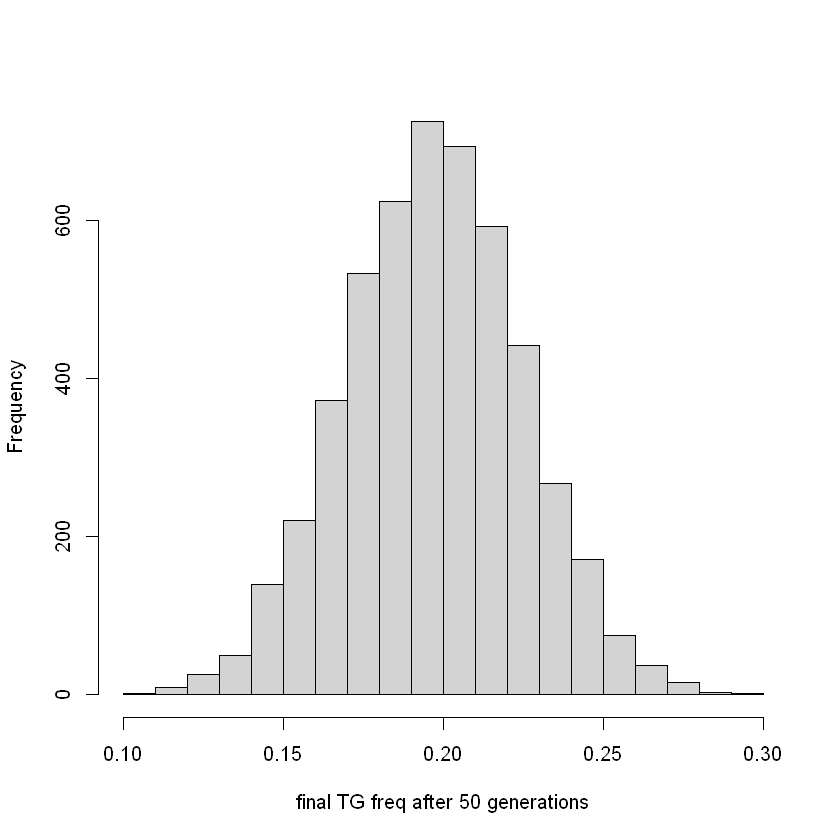

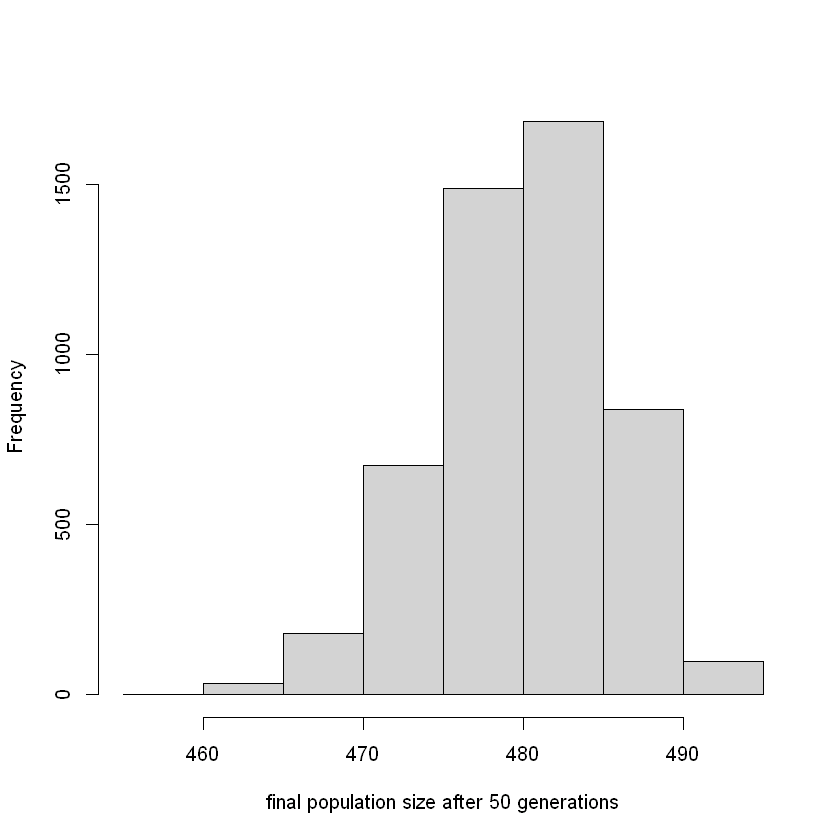

In [5]:
# SUMMARY STATISTICS
mean(result_q)
sd(result_q)
mean(result_N)
sd(result_N)

# PLOTS
hist(result_q, main='', xlab='final TG freq after 50 generations')
hist(result_N, main='', xlab='final population size after 50 generations')

The second implementation with the parallelised <code>foreach()</code> loop. My workstation has 44 cores which also doubles up as my feet warmer in winter months...

In [6]:
# SAMPLE ANALYSIS BUT WITH MULTI-CORE foreach LOOP
# FROM PACKAGE doParallel
# makeCluster(n), n MUST NOT EXCEED THE NUMBER OF CPU CORES OF YOUR PC. 
t1<-proc.time()
cl<-makeCluster(44)
registerDoParallel(cl)
result<-foreach(i=1:5000, .combine='rbind') %dopar%
{
    temp<-sim_gene_drive(q0=0.05, d=0.6, t=50, N0=500, M=500, R0=2)
    return(c(temp$TG.freq[51], temp$population.size[51]))
}
stopCluster(cl)
result_q<-result[,1]
result_N<-result[,2]
# REPORT COMPUTING TIME
t2<-proc.time()
t2-t1
rm(t1); rm(t2);

   user  system elapsed 
   6.32    1.23   19.07 

[1] 0.1971397

[1] 0.02732979

[1] 480.3938

[1] 5.501816

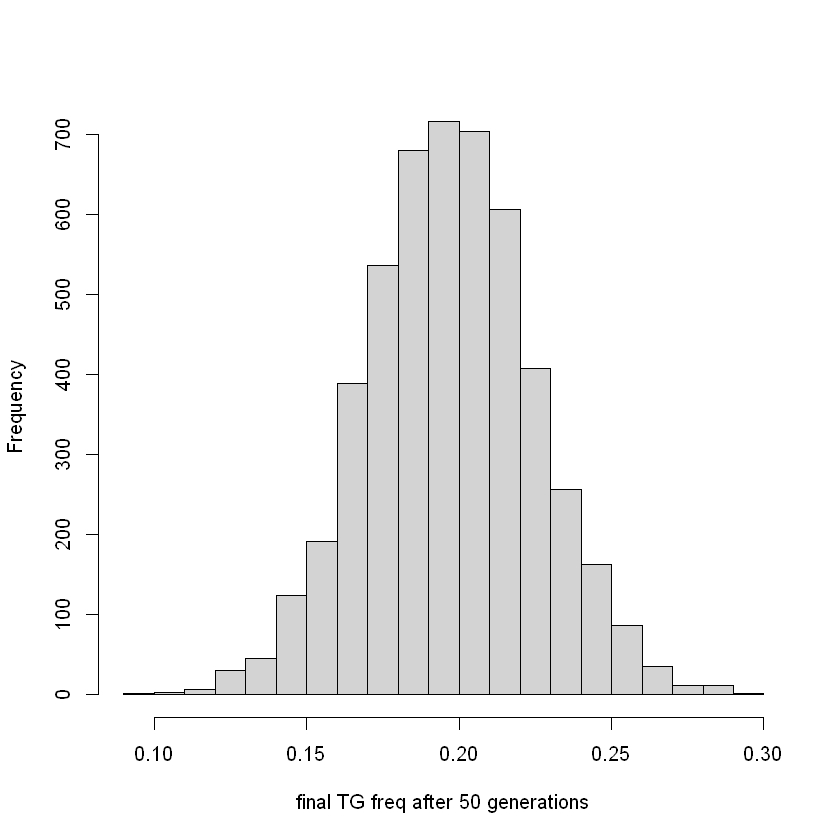

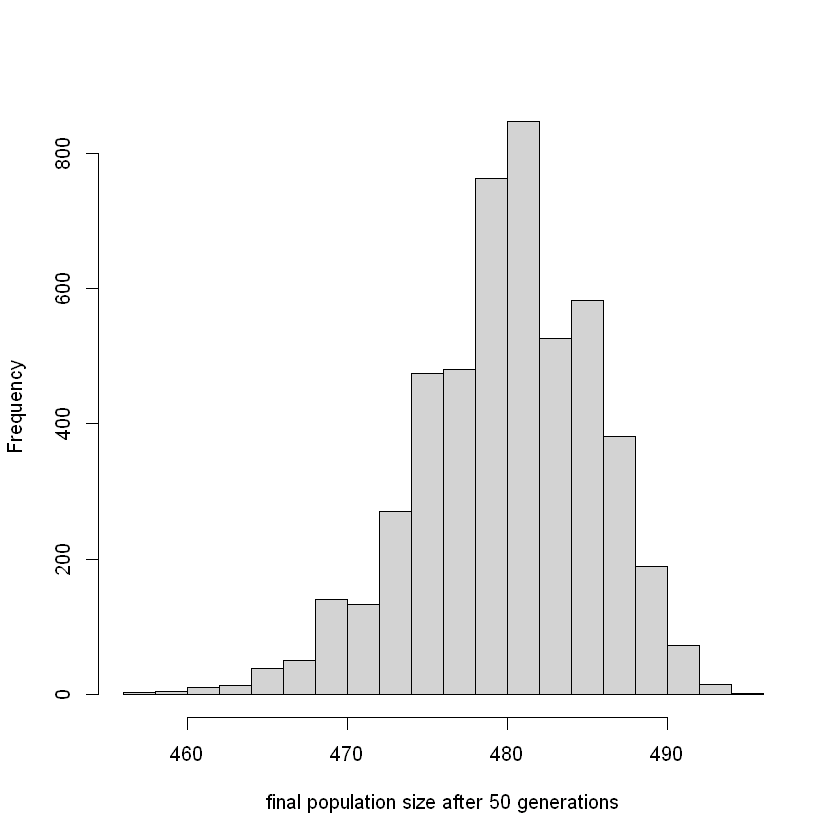

In [7]:
# SUMMARY STATISTICS, SHOULD BE SIMILAR
mean(result_q)
sd(result_q)
mean(result_N)
sd(result_N)
# PLOTS
hist(result_q, main='', xlab='final TG freq after 50 generations')
hist(result_N, main='', xlab='final population size after 50 generations')

In terms of results, the final TG frequency is higher than $q_0$, confirming the spread of TG! But it has a very minor impact on the population size (average=480, a slight reduction from the carrying capacity of 500). After all it is only a relatively weak drive with $d=0.6$. 

There is also a noticable gain in performance with the <code>foreach()</code> loop. The computing time was shortened from 200+ sec to only 6 sec (~32x faster) when the 5000 independent simulations were spread across 44 cpu cores. The elapsed time (the actual time between hitting the enter button and seeing the results on your screen) was however a bit longer at because of the various overhead (e.g. creating workers nodes, passing variables, retriving results, etc). You can even submit this to the HPC as an array job, but it is probably an overkill. 

##### 4.2 Release strategy
Q) Although the TG allele is expected to spread it is still prone to loss due to drift. Below I investigate a range of releasing frequency from 0.1% to 3.1%, and study their survival probability in 20 generations. Survival is approximated by the proportion of runs with non-zero TG frequency at the end the 20th generation. For each value of releasing frequency I have 5000 independent runs. 

It takes some time to run... Go and get some coffee and biscuits... 

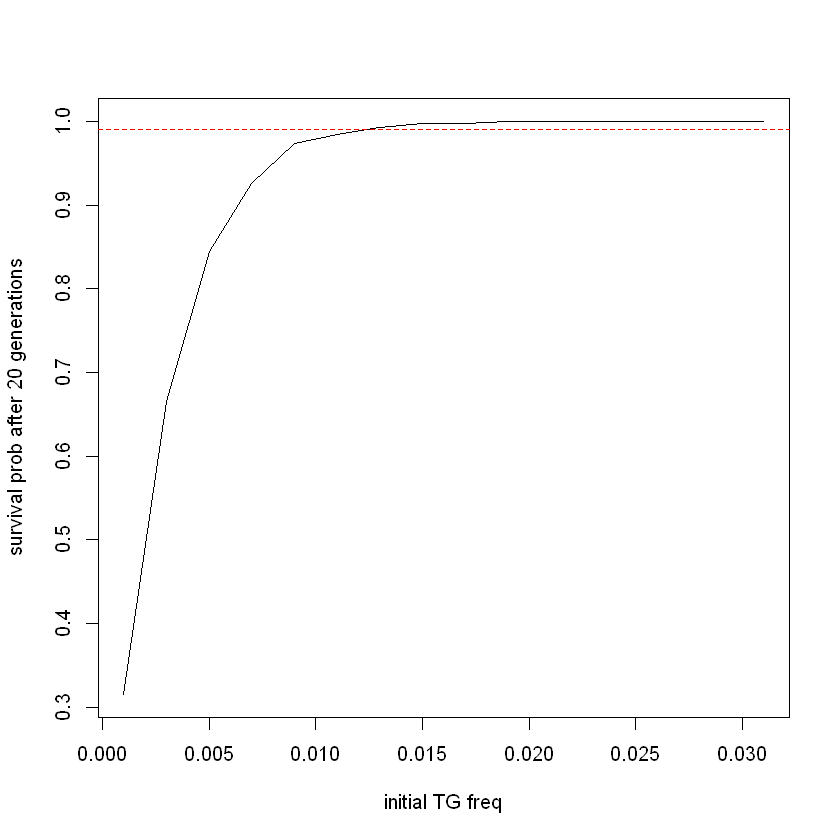

In [8]:
# STUDY A RANGE OF INITIAL RELEASING STRATEGY
initial_freq<-seq(0.001, 0.031, 0.002)
cl<-makeCluster(44)
registerDoParallel(cl)
result<-rep(NA, length(initial_freq))
for (i in 1:length(initial_freq))
{
    # SO YOU CAN PUT A foreach LOOP WITHIN A for LOOP, OR VICE-VERSA
    temp_result<-foreach(j=1:5000, .combine='c') %dopar%
    {
        temp<-sim_gene_drive(q0=initial_freq[i], d=0.6, t=20, N0=500, M=500, R0=2)
        # LOOK AT THE FINAL TG FREQ
        return(temp$TG.freq[length(temp$TG.freq)])
    }
    # SEE HOW MANY RUNS (OUT OF 5000) HAVE NON-ZERO FINAL TG FREQ. AND THIS IS THE SURVIVAL PROB. 
    result[i]<-sum(temp_result>0)
}
stopCluster(cl)
# PLOT, WITH RED 99% LINES
plot(initial_freq, result/5000, type='l', xlab='initial TG freq', ylab='survival prob after 20 generations')
abline(h=0.99, col='red', lty=2)

A) For ultra-low releasing freq of 0.1% (=releasing 1 heterozygote mosquito to a WT population of 499) the surivial is bad (~30%), and it is not a risk we are willing take. If 99% is our confidence threshold then the initial frequency should be at least 1.5%. We need to make sure our insectaries and in-country teams have the capacity to raise the number of TG mosquitoes required. And how do we estimate the population size of a wild mosquito population? 

##### 4.3 Construct design
Q) The transmission rate $d$ is a key parameter of a gene-drive construct (alongside factors such as fitness cost of the heterozygotes). What is the mimimum $d$ required if we want to reduce the population size by 80%?

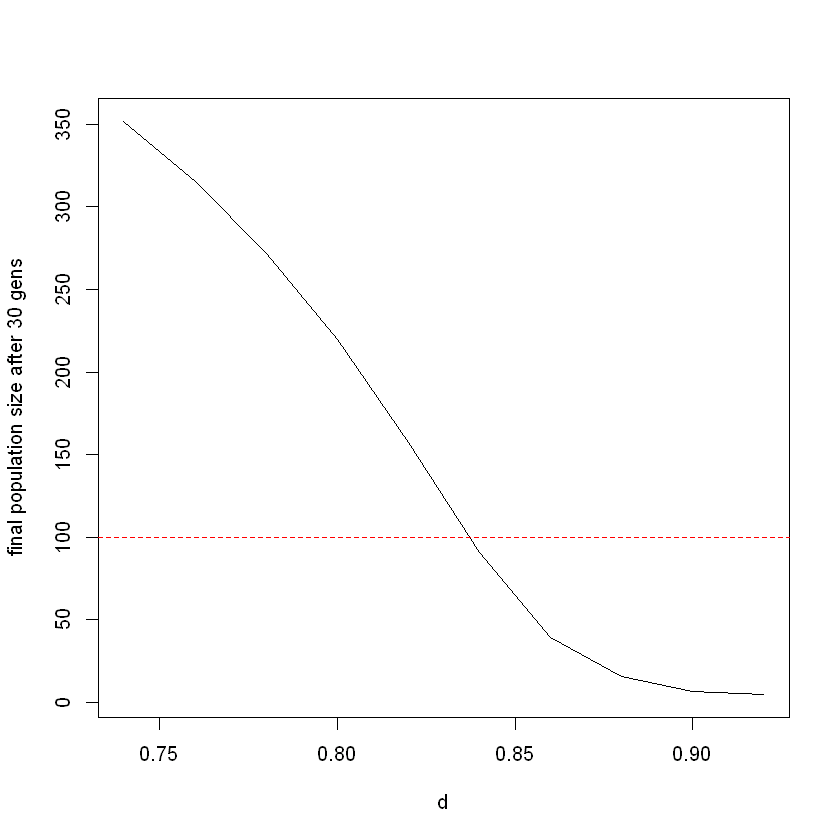

In [9]:
# STUDY A RANGE OF d
d<-seq(0.74, 0.92, 0.02)
cl<-makeCluster(44)
registerDoParallel(cl)
result<-foreach(i=1:length(d), .combine='c') %dopar%
{
    temp_result<-rep(NA, 5000)
    for (j in 1:length(temp_result))
    {
    temp<-sim_gene_drive(q0=0.03, d=d[i], t=30, N0=500, M=500, R0=2)
    temp_result[j]<-temp$population.size[length(temp$population.size)]
    }
    return(mean(temp_result))
}
stopCluster(cl)
# PLOT
plot(d, result, type='l', ylab='final population size after 30 gens')
abline(h=100, col='red', lty=2)

A) Here we look at the population size after 30 generations against a range of $d$. A conservative releasing freq of 3% is chosen based on the previous analysis. The plot agrees with our expectation that a stronger drive gives better suppression. If the aim is to reduce the population size (with respect to this particular population profile) by 80%, a minimum strength of $d=0.84$ is required. Luckily many of our candidate drives come with $d>0.90$. 

##### 4.4 Effect of population profiles
Q) Consider the following two populations: $R_0=2$ with $M=500$, and $R_0=6$ with $M=100$. While they share the same carrying capacity $(R_0-1)*M$, the latter has a much higher intrinsic growth rate. Do we expect the gene drive to behave the same in these two populations?

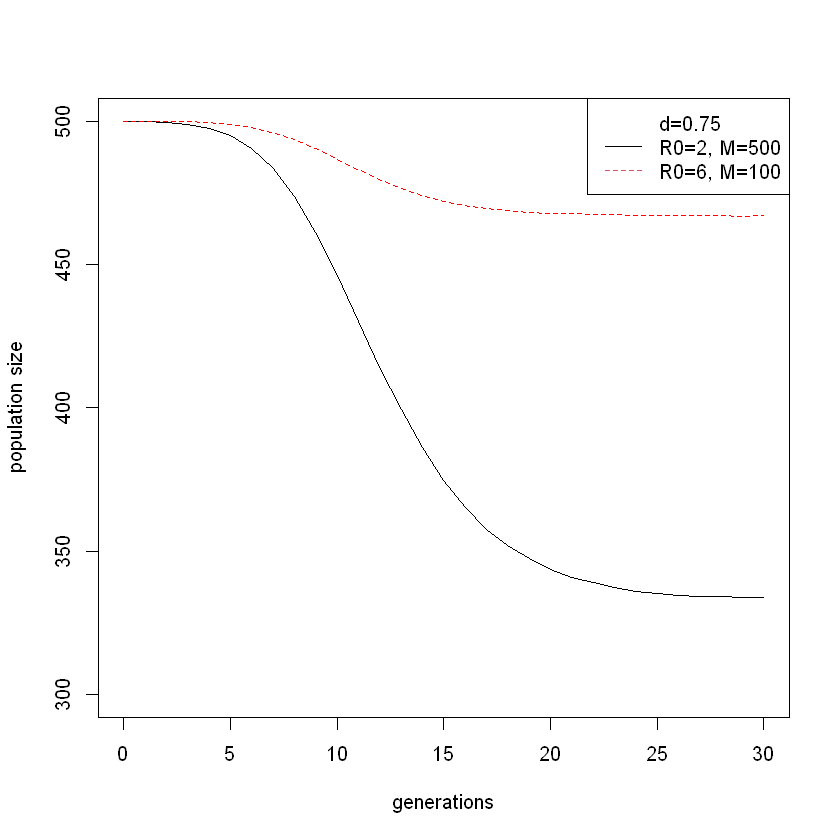

In [10]:
cl<-makeCluster(44)
registerDoParallel(cl)
# POPULATION A. R0=2, M=500
result_A<-foreach(i=1:5000, .combine='rbind') %dopar%
{
    temp<-sim_gene_drive(q0=0.03, d=0.75, t=30, N0=500, M=500, R0=2)
    return(temp$population.size)
}
# POPULATION B. R0=6, M=100
result_B<-foreach(i=1:5000, .combine='rbind') %dopar%
{
    temp<-sim_gene_drive(q0=0.03, d=0.75, t=30, N0=500, M=100, R0=6)
    return(temp$population.size)
}
stopCluster(cl)
# PLOT POPULATION SIZE OVER TIME
plot(0:30, apply(result_A, 2, mean), type='l', ylim=c(300,500), 
    ylab='population size', xlab='generations')
lines(0:30, apply(result_B, 2, mean), lty=2, col='red')
legend('topright', legend=c('d=0.75', 'R0=2, M=500', 'R0=6, M=100'), col=c(1,1,2), lty=c(NA, 1, 2))

A) The population with a higher $R_0$ gives a stronger "counterforce" to our intervention, yielding a higher equilibrium population size. 

Understanding the mosquito population dynamics is key to any vector control programmes. 

##### 4.5 Equilibrium TG frequency
The driving component is lifting the TG frequency up from its initial value via super-Mendelian inheritence, but simultaneously the TG homozygotes keep disappearing (with fitness of 0) from the population. We do not think the TG allele will become fixed - there may exist an intermediate value that the TF frequency fluctuates about. 

Below I run several simulations with different releasing frequency, with $d=0.6$ and $d=0.7$. 

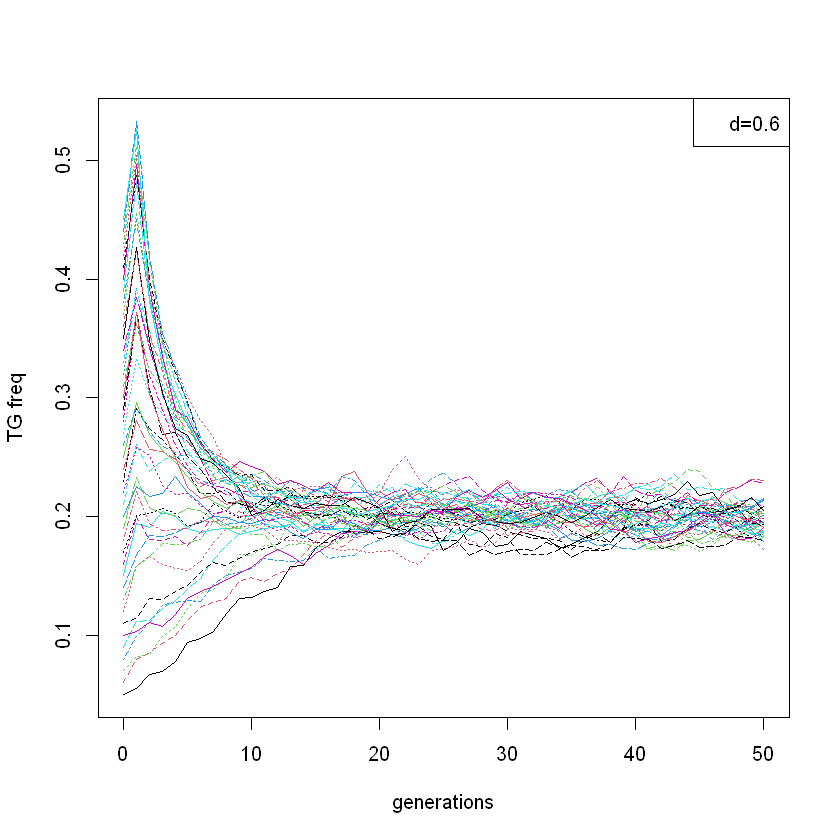

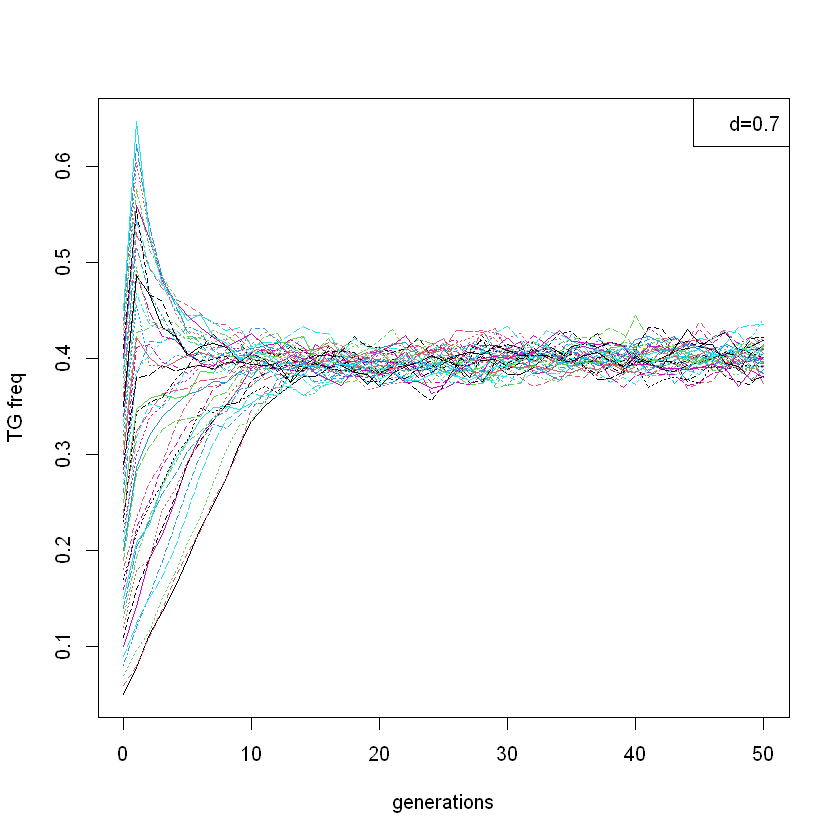

In [11]:
# d=0.6
cl<-makeCluster(44)
registerDoParallel(cl)
initial_freq<-seq(0.05, 0.45, 0.01)
result<-foreach(i=1:length(initial_freq), .combine='rbind') %dopar%
{
    temp<-sim_gene_drive(q0=initial_freq[i], d=0.6, t=50, N0=100, R0=6, M=500)
    return(temp$TG.freq)
}
stopCluster(cl)

matplot(0:50, t(result), type='l', xlab='generations', ylab='TG freq')
legend('topright', legend='d=0.6')

# d=0.7
cl<-makeCluster(44)
registerDoParallel(cl)
initial_freq<-seq(0.05, 0.45, 0.01)
result<-foreach(i=1:length(initial_freq), .combine='rbind') %dopar%
{
    temp<-sim_gene_drive(q0=initial_freq[i], d=0.7, t=50, N0=100, R0=6, M=500)
    return(temp$TG.freq)
}
stopCluster(cl)

matplot(0:50, t(result), type='l', xlab='generations', ylab='TG freq')
legend('topright', legend='d=0.7')

It appears that they all converge to a particular value after some generations. In fact, there exist an equilibrium which is independent from the intial condition (but solely dependent on $d$, exercise). 

This version of gene drive simulator is based on the model by Dederec et al. (2008). See also Burt (2003). North et al. (2020) built a much bigger model to study the spatial spread of the gene drive. The molecular features of our current candidate drive can be found here (Kyrou et al., 2018). 

I thank Alex Auyang for running the practical. 

#### Extra: The <code>doParallel</code> package
The built-in <code>for()</code> is single-threaded. We can parallelise it with a <code>foreach()</code> loop if the tasks are independent, which is usually the case in MC simulations. Random number generation is automatically "handled" by the package which is a huge advantage over HPC where it is your responsiblity to make sure the nodes are using different random seeds/states. 

Below is small example on finding the distribution of the sum of 30 chi-square random numbers. First is the traditional <code>for()</code> implementation:

In [12]:
# FOR LOOP
result<-rep(NA, 1000)
for (i in 1:1000)
{
    temp<-rchisq(30, df=1)
    result[i]<-sum(temp)
}

To parallelise this block of code, we first load the <code>doParallel</code> package and make a local cluster with a specific number of nodes. Then replace <code>for()</code> by <code>foreach()</code>, and add <code>%dopar%</code>. Note that there are other minor changes: 

In [13]:
# PARALLELISED VERSION doParallel package
# LOAD THE PACKAGE
require(doParallel)
# CREATE A LOCAL “CLUSTER” OBEJECT cl. THE NUMBER INSIDE THE BRACKET MUST NOT EXCEED YOUR CPU CORE COUNTS. REGISTER THE CLUSTER BEFORE USE. 
cl<-makeCluster(6)
registerDoParallel(cl)
# USE THE foreach LOOP WITH %dopar%
# .combine IS AN ARGUMENT SPECIFYING HOW RESULTS FROM DIFFERENT RUNS ARE COMBINED. POSSIBLE WAYS ARE c, cbind, rbind. DEFAULT IS A LIST. 
result<-foreach(i=1:1000, .combine='c') %dopar%
{
temp<-rchisq(30, df=1)
return(sum(temp))
}
# STOP THE CLUSTER AFTER USE
stopCluster(cl)

Do not forget to stop the local cluster after use. The performance gain is problem-specific but generally it is more significant in heavier tasks. 

BTW: Packages <code>doParallel</code> and <code>parallel</code> appear to be identical. Can somebody confirm it?

#### 5. References
Burt, A. (2003). Site-specific selfish genes as tools for the control and genetic engineering of natural populations. Proceedings of the Royal Society of London. Series B: Biological Sciences, 270(1518), 921-928.

Deredec, A., Burt, A., & Godfray, H. C. J. (2008). The population genetics of using homing endonuclease genes in vector and pest management. Genetics, 179(4), 2013-2026. 

North, A. R., Burt, A., & Godfray, H. C. J. (2020). Modelling the suppression of a malaria vector using a CRISPR-Cas9 gene drive to reduce female fertility. BMC biology, 18, 1-14.

Kyrou, K., Hammond, A. M., Galizi, R., Kranjc, N., Burt, A., Beaghton, A. K., ... & Crisanti, A. (2018). A CRISPR–Cas9 gene drive targeting doublesex causes complete population suppression in caged Anopheles gambiae mosquitoes. Nature biotechnology, 36(11), 1062-1066.